In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from importlib import reload as mreload
import utils
import learn
import yfinance as yf


In [2]:
mreload(utils)

df = pd.read_csv("data/BTCUSDT_1h_1_Jan_2020_23_May_2025.csv")

df["time"] = pd.to_datetime(df["timestamp"])

df["log_ret"] = np.log(df["close"]).diff()

df = utils.add_rsis(df, np.arange(2, 24 * 3 + 1))
df = utils.add_mas(df, np.arange(2, 24 * 3 + 1))
df = df.dropna().reset_index(drop=True)

df["clog_ret"] = np.cumsum(df["log_ret"])

df.index = df["time"].values

/home/mdm/coding/fintech/model_dev/learn/utils.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"means_{window_length}"] = df["close"].rolling(window_length).mean()
/home/mdm/coding/fintech/model_dev/learn/utils.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"std_{window_length}"] = df["close"].rolling(window_length).std(ddof=1)
/home/mdm/coding/fintech/model_dev/learn/utils.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def preprocess_data(features, targets, N, T, test_size=0.2, val_size=0.1, scaledown=1e-3, random_state=42):
    """
    Args:
        features: 2D numpy array (timesteps × features)
        targets: 1D numpy array (timesteps,)
        N: Prediction horizon (hours ahead to predict)
        T: Sequence length (historical window size)
    Returns:
        (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    # 1. Remove samples with NaN targets (from shifting)
    features = features[:-N]
    targets = targets[:-N]

    # 2. Time-based splitting
    train_size = int((1 - test_size - val_size) * len(features))
    val_split = train_size + int(val_size * len(features))

    
    
    # Features
    X_train = features[:train_size]
    X_val = features[train_size:val_split]
    X_test = features[val_split:]

    print(f"x_train: {len(X_train)}, x_val: {len(X_val)}, x_test: {len(X_test)}")
    
    # Targets
    y_train = targets[:train_size]
    y_val = targets[train_size:val_split]
    y_test = targets[val_split:]

    # 3. Feature scaling
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)

    print(f"X train mean: {X_train_scaled[:,0].mean()}, X train std: {X_train_scaled[:,0].std()}")
    print(f"X val mean: {X_val_scaled[:,0].mean()}, X val std: {X_val_scaled[:,0].std()}")
    print(f"X test mean: {X_test_scaled[:,0].mean()}, X test std: {X_test_scaled[:,0].std()}")

    # 4. Dimensionality reduction (optional)
    pca = PCA(n_components=3)  # Keep 95% variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    

    # X_train_pca = np.nancumsum(X_train_pca, axis=0)
    # X_val_pca = np.nancumsum(X_val_pca, axis=0)
    # X_test_pca = np.nancumsum(X_test_pca, axis=0)
    # feature_minmax_scaler = MinMaxScaler()
    # X_train_pca = feature_minmax_scaler.fit_transform(X_train_pca)
    # X_val_pca = feature_minmax_scaler.transform(X_val_pca)
    # X_test_pca = feature_minmax_scaler.transform(X_test_pca)



    # 5. Target scaling
    target_scaler = StandardScaler()
    target_scaler.fit(y_train.reshape(-1,1))

    y_train_scaled = target_scaler.transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()


    print(f"y train mean: {y_train_scaled[:].mean()}, y train std: {y_train_scaled[:].std()}")
    print(f"y val mean: {y_val_scaled[:].mean()}, y val std: {y_val_scaled[:].std()}")
    print(f"y test mean: {y_test_scaled[:].mean()}, y test std: {y_test_scaled[:].std()}")


    # target_minmax_scaler = MinMaxScaler()
    # y_train_scaled = target_minmax_scaler.fit_transform(y_train_scaled.reshape(-1,1)).flatten()
    # y_val_scaled = target_minmax_scaler.transform(y_val_scaled.reshape(-1,1)).flatten()
    # y_test_scaled = target_minmax_scaler.transform(y_test_scaled.reshape(-1,1)).flatten()

    


    # 6. Create sequences
    def create_sequences(X, y):
        sequences = []
        labels = []
        for i in range(len(X) - T + 1):
            sequences.append(X[i:i+T])
            labels.append(y[i+T-1])  # Predict N hours from last point in sequence
        return np.array(sequences), np.array(labels)
    
    X_train_seq, y_train_seq = create_sequences(X_train_pca, y_train_scaled)
    X_val_seq, y_val_seq = create_sequences(X_val_pca, y_val_scaled)
    X_test_seq, y_test_seq = create_sequences(X_test_pca, y_test_scaled)

    return (X_train_seq, y_train_seq), (X_val_seq, y_val_seq), (X_test_seq, y_test_seq), feature_scaler, target_scaler, pca, train_size, val_split

# --------------------------------------------------


In [4]:
train_period = pd.DateOffset(months=12) #6 months
test_period = pd.DateOffset(months=2)


chop_point = df.index.min() + pd.DateOffset(months=36)

dfchop = (df.index <= chop_point)
dfshort = df.copy()
dfshort = dfshort[dfchop]

df_final = df


features = utils.get_features_matrix(df_final)

# 1. Create target vector (log returns)
N = 4  # Predict 6 hours ahead
log_returns = np.log(df_final['close'].shift(-N)) - np.log(df_final['close'])
# Or absolute returns: targets = df['close'].shift(-N) - df['close']

# 2. Run preprocessing
T = 24 * 1  # Use 24-hour historical window
(X_train, y_train), (X_val, y_val), (X_test, y_test), feat_scaler, target_scaler, pca, train_size, val_split = preprocess_data(
    features=features.values,
    targets=log_returns.values,
    N=N,
    T=T,
    test_size=0.1,
    val_size=0.2,
)

# 3. Verify shapes
print(f"Train sequences: {X_train.shape}")  # (num_sequences, T, num_features)
print(f"Targets: {y_train.shape}")         # (num_sequences,)
print(f"train time: {df_final["time"].iloc[0]} - {df_final["time"].iloc[train_size]}")
print(f"test time: {df_final["time"].iloc[train_size]} - {df_final["time"].iloc[val_split]}")
print(f"validation time: {df_final["time"].iloc[val_split]} - {df_final["time"].iloc[-1]}")

x_train: 33004, x_val: 9429, x_test: 4716
X train mean: 7.36829630692929e-17, X train std: 1.0
X val mean: 0.029891002286939965, X val std: 1.0005884039860589
X test mean: 0.027151402845846218, X test std: 1.0108054222439797
y train mean: -6.0550280097117975e-18, y train std: 1.0
y val mean: 0.01874435234832617, y val std: 0.7194559982627158
y test mean: 0.012129917727531256, y test std: 0.7663747228712295
Train sequences: (32981, 24, 3)
Targets: (32981,)
train time: 2020-01-04 00:00:00 - 2023-10-11 12:00:00
test time: 2023-10-11 12:00:00 - 2024-11-07 09:00:00
validation time: 2024-11-07 09:00:00 - 2025-05-23 00:00:00


In [5]:
4172 + 14599

18771

In [6]:
4172/2

2086.0

In [7]:
y_test.shape

(4693,)

In [61]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMReg(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, num_layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )


        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim *2 ),
            nn.BatchNorm1d(hidden_dim *2),
            nn.ReLU(),
            nn.Dropout(0.05),


            nn.Linear(hidden_dim *2 , hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim *2),
            nn.ReLU(),
            nn.Dropout(0.05),


            nn.Linear(hidden_dim *2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.05),

            nn.Linear(hidden_dim, output_dim)
        )       
          
    


        # self.a = nn.Parameter(torch.ones(1))
        # self.b = nn.Parameter(torch.zeros(1))
    #     self._init_weights()

    # def _init_weights(self):
    #     # your existing init scheme for lstm & fc
    #     for name, param in self.named_parameters():
    #         if 'weight_ih' in name:
    #             nn.init.xavier_uniform_(param)
    #         elif 'weight_hh' in name:
    #             nn.init.orthogonal_(param)
    #         elif 'bias' in name:
    #             nn.init.zeros_(param)

    

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        h_last = lstm_out[:, -1, :]
        h_last = self.layer_norm(h_last)
        raw = self.fc(h_last)

        # raw = 100*raw/raw.max() - (100*raw/raw.max()).mean()         # shape (batch,1)
        return raw #self.a * raw + self.b  # calibrated output

# Modify loss function
class SmoothMSELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.base_loss = nn.MSELoss()
        
    def forward(self, inputs, targets):
        targets = targets * (1 - self.smoothing) + torch.randn_like(targets) * self.smoothing
        return self.base_loss(inputs, targets)


def mape_loss(y_pred, y_true, eps=1e-6):
    # eps avoids division by zero
    return torch.mean( torch.abs((y_pred - y_true) / (torch.abs(y_true) + eps)) )


In [62]:
# import torch
# import torch.nn as nn

# class LSTMReg(nn.Module):
#     def __init__(
#         self,
#         input_dim,           # number of features in each time step
#         hidden_dim=64,       # hidden size of the LSTM
#         output_dim=1,        # dimension of the regression output
#         num_layers=1,        # number of LSTM layers
#         dropout=0.0,         # dropout between LSTM layers
#         fc_dropout=0.1,      # dropout in the FC head
#         target_scale=1.0,    # for undoing standardization
#         target_shift=0.0     # for undoing standardization
#     ):
#         super(LSTMReg, self).__init__()

#         # 1) LSTM encoder
#         self.lstm = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0.0
#         )

#         # 2) BatchNorm on hidden-state (optional, can remove)
#         self.bn   = nn.BatchNorm1d(hidden_dim)

#         # 3) Learnable “amplifier” on the hidden state
#         self.scale_param = nn.Parameter(torch.ones(1) * 2.0)

#         # 4) Fully-connected head: takes [hidden_dim + input_dim] → output_dim
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim + input_dim, 64),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(fc_dropout),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(fc_dropout),
#             nn.Linear(32, output_dim),
#         )

#         # 5) Final learnable scale & shift back to original target space
#         self.target_scale = nn.Parameter(torch.tensor([target_scale], dtype=torch.float))
#         self.target_shift = nn.Parameter(torch.tensor([target_shift], dtype=torch.float))

#         # 6) Weight initialization
#         self._init_weights()

#     def _init_weights(self):
#         # Initialize FC with Kaiming to give more initial variance
#         for layer in self.fc:
#             if isinstance(layer, nn.Linear):
#                 nn.init.kaiming_normal_(layer.weight, nonlinearity='linear')
#                 nn.init.zeros_(layer.bias)

#         # Init the last bias so we start at the target mean
#         with torch.no_grad():
#             self.fc[-1].bias.fill_(self.target_shift.item())

#     def forward(self, x, debug=False):
#         """
#         x: tensor of shape (batch_size, seq_length, input_dim)
#         debug: if True, prints hidden-state std
#         """
#         # 1) Encode with LSTM
#         lstm_out, _ = self.lstm(x)              # (B, T, hidden_dim)
#         h_last = lstm_out[:, -1, :]             # (B, hidden_dim)

#         # 2) (Optional) report hidden-state variance
#         if debug:
#             print(f"▶ hidden std: {h_last.std(dim=0).mean().item():.4f}")

#         # 3) BatchNorm + learnable amplification
#         h_norm = self.bn(h_last)                # (B, hidden_dim)
#         h_amp  = h_norm * self.scale_param      # (B, hidden_dim)

#         # 4) Grab the raw last input as a residual skip
#         last_in = x[:, -1, :]                   # (B, input_dim)

#         # 5) Concatenate and feed into FC head
#         combined = torch.cat([h_amp, last_in], dim=1)  # (B, hidden_dim + input_dim)
#         raw_out  = self.fc(combined)                   # (B, output_dim)

#         # 6) Undo standardization inside the model
#         y_pred = raw_out * self.target_scale + self.target_shift

#         return y_pred


# class LSTMReg(nn.Module):
#     def __init__(
#         self,
#         input_dim,           # number of features in each time step
#         hidden_dim=64,       # hidden size of the LSTM
#         output_dim=1,        # dimension of the regression output
#         num_layers=1,        # number of LSTM layers
#         dropout=0.0,         # dropout between LSTM layers
#         fc_dropout=0.1,      # dropout in the FC head
#         target_scale=1.0,    # for undoing standardization
#         target_shift=0.0     # for undoing standardization
#     ):
#         super(LSTMReg, self).__init__()

#         # 1) LSTM encoder
#         self.lstm = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0.0
#         )

#         # 2) BatchNorm on hidden-state (optional, can remove)
#         self.bn   = nn.BatchNorm1d(hidden_dim)

#         # 3) Learnable “amplifier” on the hidden state
#         self.scale_param = nn.Parameter(torch.ones(1) * 2.0)

#         # 4) Fully-connected head: takes [hidden_dim + input_dim] → output_dim
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim + input_dim, 64),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(fc_dropout),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.1),
#             nn.Dropout(fc_dropout),
#             nn.Linear(32, output_dim),
#         )

#         # 5) Final learnable scale & shift back to original target space
#         self.target_scale = nn.Parameter(torch.tensor([target_scale], dtype=torch.float))
#         self.target_shift = nn.Parameter(torch.tensor([target_shift], dtype=torch.float))

#         # 6) Weight initialization
#         self._init_weights()

#     def _init_weights(self):
#         # Initialize FC with Kaiming to give more initial variance
#         for layer in self.fc:
#             if isinstance(layer, nn.Linear):
#                 nn.init.kaiming_normal_(layer.weight, nonlinearity='linear')
#                 nn.init.zeros_(layer.bias)

#         # Init the last bias so we start at the target mean
#         with torch.no_grad():
#             self.fc[-1].bias.fill_(self.target_shift.item())

#     def forward(self, x, debug=False):
#         """
#         x: tensor of shape (batch_size, seq_length, input_dim)
#         debug: if True, prints hidden-state std
#         """
#         # 1) Encode with LSTM
#         lstm_out, _ = self.lstm(x)              # (B, T, hidden_dim)
#         h_last = lstm_out[:, -1, :]             # (B, hidden_dim)

#         # 2) (Optional) report hidden-state variance
#         if debug:
#             print(f"▶ hidden std: {h_last.std(dim=0).mean().item():.4f}")

#         # 3) BatchNorm + learnable amplification
#         h_norm = self.bn(h_last)                # (B, hidden_dim)
#         h_amp  = h_norm * self.scale_param      # (B, hidden_dim)

#         # 4) Grab the raw last input as a residual skip
#         last_in = x[:, -1, :]                   # (B, input_dim)

#         # 5) Concatenate and feed into FC head
#         combined = torch.cat([h_amp, last_in], dim=1)  # (B, hidden_dim + input_dim)
#         raw_out  = self.fc(combined)                   # (B, output_dim)

#         # 6) Undo standardization inside the model
#         y_pred = raw_out * self.target_scale + self.target_shift

#         return y_pred



In [63]:
X_train[:,:,:].shape

(32981, 24, 3)

In [64]:
y_train.shape

(32981,)

In [65]:
def create_const(y, c):

    xdummy = np.ones_like(y)
    ydummy = c * xdummy
    return ydummy

def create_line(y, c):
    xdummy = np.arange(y.size)
    ydummy = (c / xdummy.size) * xdummy
    return ydummy



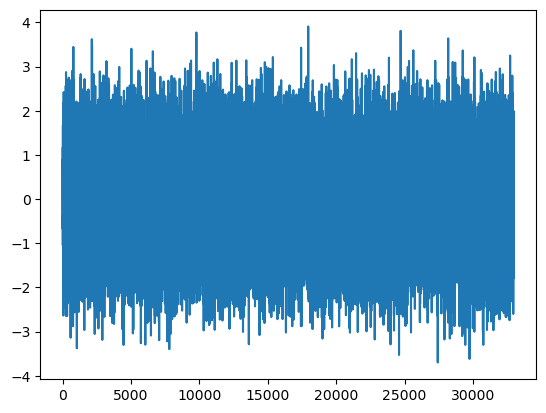

In [66]:
from scipy import stats

xdummy = np.ones_like(X_train)
ydummy = stats.norm.rvs(loc=0, scale=1, size=(y_train.shape))

xdummy2 = np.ones_like(X_test)
ydummy2 = stats.norm.rvs(loc=0, scale=1, size=(y_test.shape))

xdummy3 = np.ones_like(X_val)
ydummy3 = stats.norm.rvs(loc=0, scale=1, size=(y_val.shape))

plt.plot(ydummy)

In [67]:
import torch.nn.functional as F

class MomentMatchingLoss(torch.nn.Module):
    def __init__(self, alpha=0.1, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor):
        # Base MSE
        mse = F.l1_loss(pred, true)

        # Compute variances over the batch
        var_p = pred.var(unbiased=False)       # shape: scalar
        var_t = true.var(unbiased=False)       # shape: scalar

        # Relative variance‐matching penalty
        var_ratio = var_p / (var_t + self.eps)
        var_loss  = (var_ratio - 1.0).abs()

        return mse + self.alpha * var_loss
    

class CalibrationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, y_hat):
        # y_hat: (B,)
        return self.net(y_hat).squeeze(-1)
    

class OutputScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(1))   # learnable multiplier (a)
        self.shift = nn.Parameter(torch.zeros(1))  # learnable offset (b)

    def forward(self, x):
        return self.scale * x + self.shift
    
class ScaledModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.scaler = CalibrationHead()

    def forward(self, x):
        base_output = self.base_model(x)
        return self.scaler(base_output)

In [ ]:
norm = y_train.max()
scaledown = 1e-3
# 1. Convert data to PyTorch tensors



train_dataset = TensorDataset(torch.FloatTensor((X_train)), torch.FloatTensor(1 * y_train )) #y_train
val_dataset = TensorDataset(torch.FloatTensor((X_val)), torch.FloatTensor(1 * y_val )) #y_val
test_dataset = TensorDataset(torch.FloatTensor((X_test)), torch.FloatTensor(1 * y_test )) #y_test


# # playing around
# train_dataset = TensorDataset(torch.FloatTensor((xdummy)), torch.FloatTensor(1 * ydummy )) 
# val_dataset = TensorDataset(torch.FloatTensor((xdummy3)), torch.FloatTensor(1 * ydummy3 )) 
# test_dataset = TensorDataset(torch.FloatTensor((xdummy2)), torch.FloatTensor(1 * ydummy2 )) 



#  #2. Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMReg(
    input_dim=X_train.shape[-1],
    hidden_dim=32,
    num_layers=1,
    dropout=0.05
).to(device)


# model = ScaledModel(model).to(device)


# model.fc[-1].bias.data.fill_(float(target_scaler.mean_))

criterion = MomentMatchingLoss(0.05) #nn.L1Loss() #mape_loss #nn.L1Loss() #nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4, weight_decay=1e-4, momentum_decay=0.004)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-4,
    max_lr=1e-3,
    step_size_up=500,
    cycle_momentum=False
)

# 4. Training loop with validation
best_val_loss = float('inf')
patience =   5
epochs_no_improve = 0
early_stop = False

train_losses = []
val_losses = []

torch_mu  = torch.tensor(np.array([target_scaler.mean_ ]), dtype=torch.float).to(device)
torch_sigma  = torch.tensor(np.array([target_scaler.scale_ ]), dtype=torch.float).to(device)

for epoch in range(25):
    if early_stop:
        print("Early stopping!")
        break

        # Training
    model.train()
    epoch_train_loss = []
    for i, (X_batch, y_batch) in enumerate(train_loader):

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)        

        optimizer.zero_grad()
        outputs = model(X_batch)
        # outputs = torch_sigma * outputs + torch_mu

        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()

        epoch_train_loss.append(loss.item())


    
    # Validation
    model.eval()
    epoch_val_loss = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            # val_outputs = torch_sigma * val_outputs + torch_mu
            
            val_outputs = val_outputs.to(device)
            val_loss = criterion(val_outputs.squeeze(), y_val_batch)
            epoch_val_loss.append(val_loss.item())


    
    # Metrics
    train_loss = np.mean(epoch_train_loss)
    val_loss = np.mean(epoch_val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    # scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            early_stop = True
    
    print(f'Epoch {epoch+1:03}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

# 5. Final evaluation on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        preds = model(X_test_batch)
        # preds = torch_sigma * preds + torch_mu
        preds = preds.cpu().numpy().flatten()
        preds = target_scaler.transform(preds.reshape(-1,1)).flatten()
        all_preds.extend(preds)
        all_targets.extend(y_test_batch.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Inverse scaling
all_preds_sc =  target_scaler.inverse_transform((all_preds.reshape(-1, 1))).flatten()
all_targets_sc = target_scaler.inverse_transform(((all_targets).reshape(-1, 1))).flatten()

# Calculate metrics
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)

print(f'\nTest Results:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

# 6. Visualization (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Epoch 001: Train Loss: 0.6866 | Val Loss: 0.5337 | LR: 1.00e-04
Epoch 002: Train Loss: 0.6712 | Val Loss: 0.5319 | LR: 1.00e-04
Epoch 003: Train Loss: 0.6672 | Val Loss: 0.5301 | LR: 1.00e-04
Epoch 004: Train Loss: 0.6652 | Val Loss: 0.5298 | LR: 1.00e-04
Epoch 005: Train Loss: 0.6645 | Val Loss: 0.5327 | LR: 1.00e-04
Epoch 006: Train Loss: 0.6636 | Val Loss: 0.5359 | LR: 1.00e-04
Epoch 007: Train Loss: 0.6628 | Val Loss: 0.5351 | LR: 1.00e-04
Epoch 008: Train Loss: 0.6621 | Val Loss: 0.5316 | LR: 1.00e-04


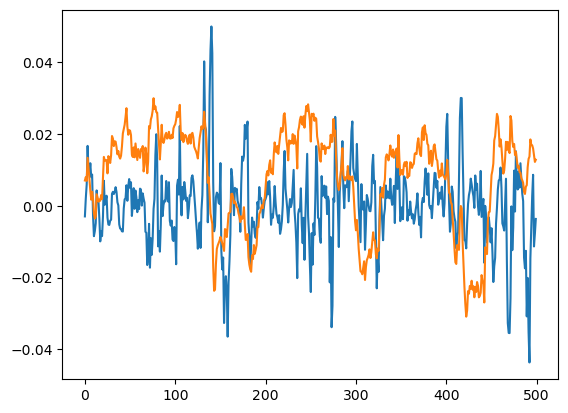

In [22]:
all_targets = np.array(all_targets) #target_scaler.inverse_transform(np.array(all_targets).reshape(-1,1)).flatten()

all_preds = np.array(all_preds) #target_scaler.inverse_transform(np.array(all_preds).reshape(-1,1)).flatten()


plt.plot((all_targets_sc )[500:1000]) #/all_targets.max())
plt.plot(( all_preds_sc )[500:1000] ) #/all_preds.max())
# plt.ylim(0, 2)

In [23]:
all_preds.std()

1.1200733

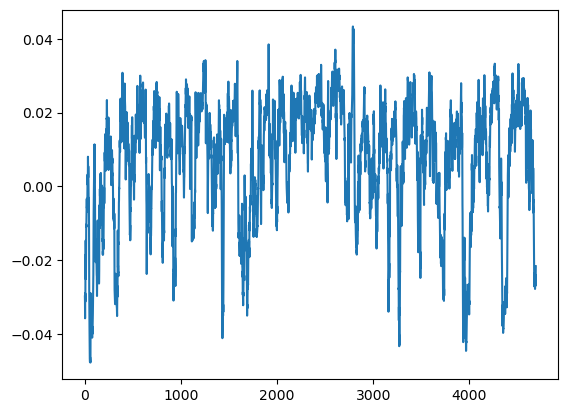

In [24]:
# plt.plot(all_targets_sc) #/all_targets.max())
plt.plot(all_preds_sc) 

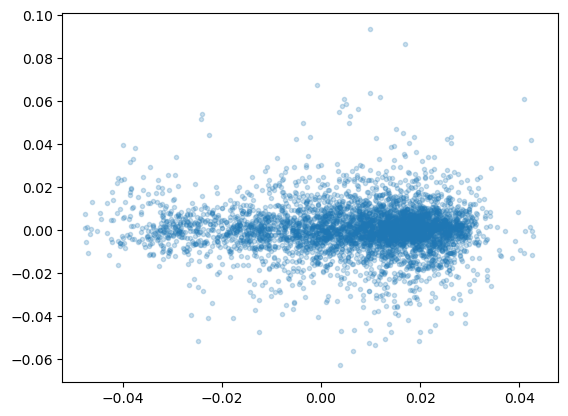

In [26]:
plt.plot(1*all_preds_sc, all_targets_sc, "o", ms=3, alpha=0.23)
# plt.xlim( 0.)

In [173]:
type(X_train)

numpy.ndarray

In [27]:
Xt = torch.FloatTensor(X_train).to(device)
train_loader_ordered = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# model.to("cpu")
model.eval()
overfit = []


with torch.no_grad():

     for _xt, _yt in train_loader_ordered:
          _xt = _xt.to(device)
          _overfit = model(_xt).cpu().numpy().flatten()
          _overfit = (_overfit - _overfit.mean()) / _overfit.std()
          overfit.extend(_overfit.tolist())


overfit = np.array(overfit)

6.413043244955329


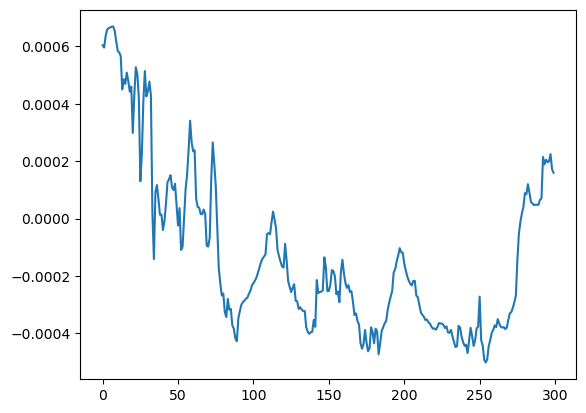

In [32]:

y_pred = []
y_t = []

with torch.no_grad():

     for _xt, _yt in val_loader:
            _xt = _xt.to(device)
            _yt = _yt.to(device)
            _y_pred = model(_xt).cpu().numpy().flatten()

          #   _y_pred = (_y_pred - _y_pred.mean()) / _y_pred.std()
            y_pred.extend(_y_pred.tolist())
            y_t.extend(_yt.cpu().numpy().tolist())

y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1,1)).flatten()
y_t = target_scaler.inverse_transform(np.array(y_t).reshape(-1,1)).flatten()


# y_pred = (y_pred - y_pred.mean()) / y_pred.std()
# y_t = (y_t -y_t.mean()) / y_t.std()

# plt.plot(y_t[:300])
plt.plot(1 * y_pred[:300])

print(y_t.mean() / y_pred.mean())



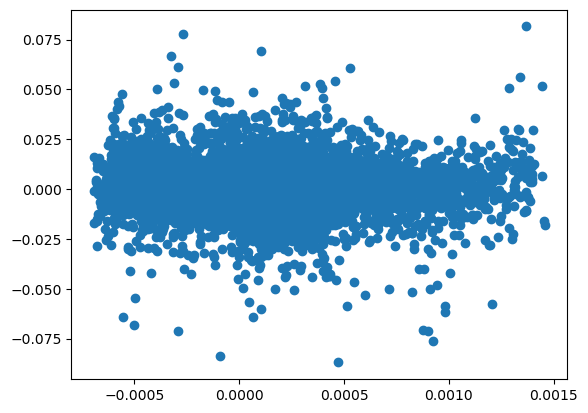

In [33]:
plt.plot(y_pred, y_t, "o")

In [34]:
y_pred

array([ 0.00060345,  0.00059546,  0.00063608, ..., -0.00012366,
       -0.00013962, -0.00019755])

In [35]:
(y_pred - y_pred.mean()) / np.nanstd(y_pred)

array([ 1.32233341,  1.30257574,  1.40292907, ..., -0.47403795,
       -0.5134604 , -0.65657852])

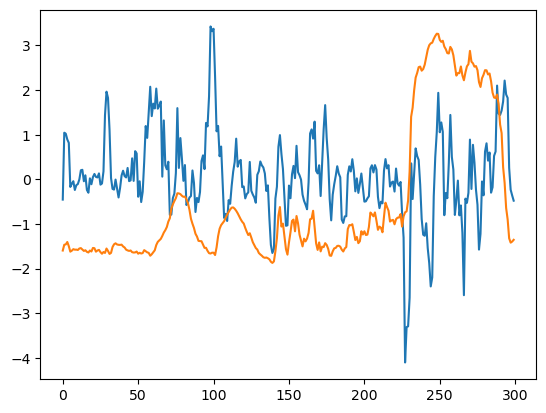

In [36]:
std_y_t = (y_t - y_t.mean()) / (y_t.std())

std_y_pred = (y_pred - y_pred.mean()) / (y_pred.std())

plt.plot(std_y_t[1200:1500])
plt.plot(std_y_pred[1200:1500])

In [37]:
# from torch.autograd import Variable
# cal = CalibrationHead().to(device)



# class CalibrationHead(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(1, 16),
#             nn.ReLU(),
#             nn.Linear(16, 64),
#             nn.ReLU(),

#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
#         )

#     def forward(self, y_hat):
#         # y_hat: (B,)
#         return self.net(y_hat.unsqueeze(-1)).squeeze(-1)

# criterion2 = MomentMatchingLoss(alpha=0.1)
# optimizer = optim.Adam(cal.parameters(), lr=1e-4)



# inp = torch.tensor((std_y_pred), dtype=torch.float).to(device)
# outp = torch.tensor((std_y_t),   dtype=torch.float).to(device)


# cal_dataset = TensorDataset(inp, outp)
# cal_loader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=False)

# l = []
# num_epochs = 10
# for epoch in range(num_epochs):
#     cal.train()
#     epoch_loss = 0

#     for batch_inp, batch_outp in cal_loader:
#         optimizer.zero_grad()
#         calibrated_out = cal(batch_inp)                   # (B,)
#         loss = criterion2(calibrated_out, batch_outp)     # (B,)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * batch_inp.size(0)     # Weighted sum for avg loss

        

#     avg_loss = epoch_loss / len(cal_dataset)
#     l.append(avg_loss)
#     print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")



In [38]:
# plt.plot(cal(inp).detach().cpu().numpy())

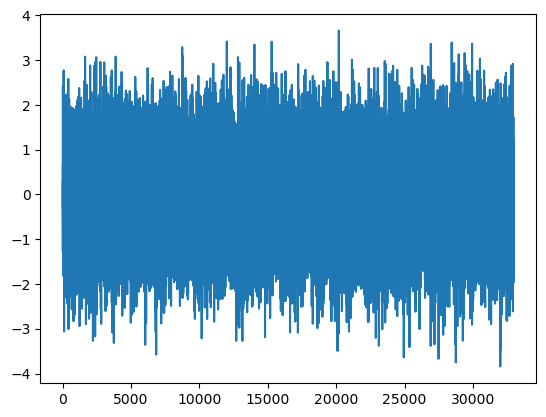

In [39]:
# plt.plot(y_train[:])
plt.plot(1*overfit[:])

In [40]:
# gt = target_scaler.inverse_transform(y_train[:].reshape(-1,1))
# ofit = target_scaler.inverse_transform(overfit[:].reshape(-1,1))


# uq = np.quantile(ofit, 0.90)
# # plt.plot(gt[:500])
# _x = ofit[500:1000]
# plt.plot(_x/_x.max() -  (_x/_x.max()).mean())


# _y=target_scaler.inverse_transform(y_train.reshape(-1,1))[500:1000]
# plt.plot(_y/_y.max())
# # plt.axhline(y=uq)



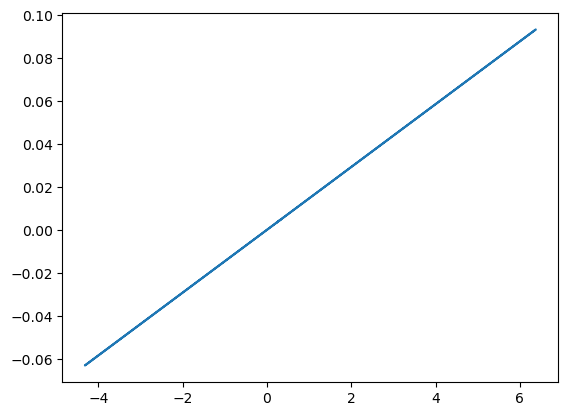

In [41]:
plt.plot(all_targets, target_scaler.inverse_transform(y_test.reshape(-1,1)).ravel())


Critical Scaling Factor: 0.014608207071886684
Prediction/Target STD Ratio: 146.02%


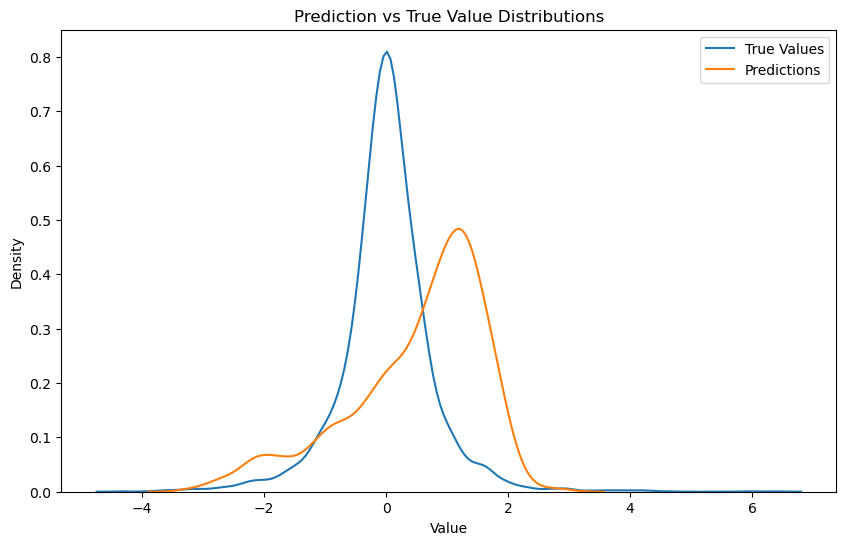

In [42]:
# Analyze scaling factors
scale_factor = target_scaler.scale_[0]
print(f"\nCritical Scaling Factor: {scale_factor}")

# Check prediction magnitudes
pred_scale_ratio = np.std(all_preds) / np.std(all_targets)
print(f"Prediction/Target STD Ratio: {pred_scale_ratio:.2%}")

# Plot density comparison
plt.figure(figsize=(10,6))
sns.kdeplot(all_targets, label='True Values')
sns.kdeplot(all_preds, label='Predictions')
plt.title("Prediction vs True Value Distributions")
plt.xlabel("Value")
plt.legend()
plt.show()

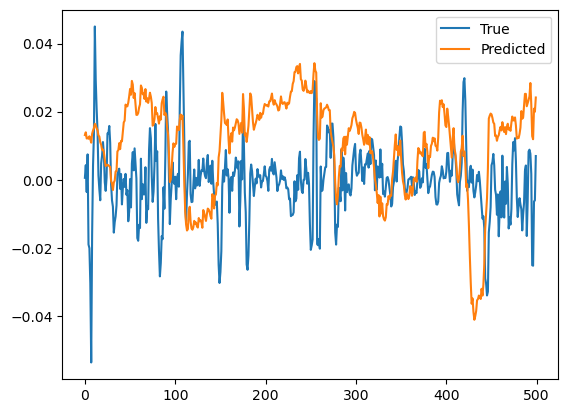

In [43]:
plt.plot(all_targets_sc[1000:1500], label='True')
plt.plot(1*np.array(all_preds_sc[1000:1500])  , label='Predicted') 
plt.legend()

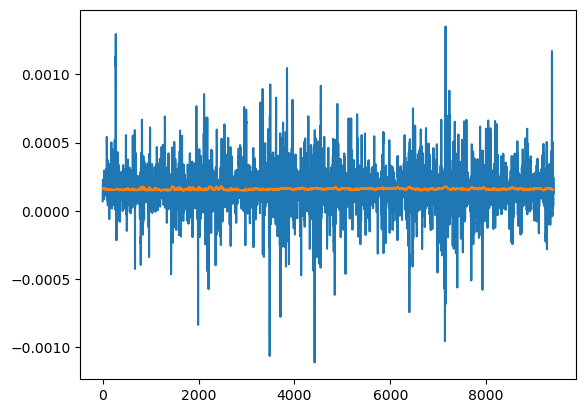

In [44]:
plt.plot(target_scaler.inverse_transform(y_t.reshape(-1,1)).flatten())
plt.plot(target_scaler.inverse_transform( y_pred.reshape(-1,1)).flatten())

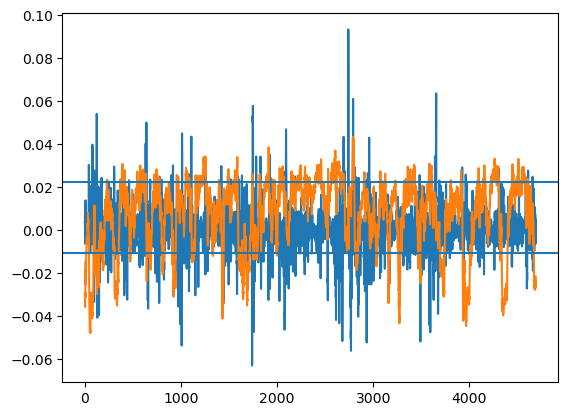

In [48]:



_y=  y_pred   #[500:1000]

_x = y_t #  #[500:1000]


norm = _x.max()
norm2 = _y.max()

y_pred_cal = all_preds_sc #target_scaler.inverse_transform(y_t.reshape(-1,1)).flatten() # std_y_pred #_y/norm2  - 1*(_y/norm2).mean()
y_gt_cal = all_targets_sc #target_scaler.inverse_transform( y_pred.reshape(-1,1)).flatten() # std_y_t #_x/norm - 1.*(_x/norm).mean()





plt.plot((y_gt_cal)[:])
plt.plot(y_pred_cal[:])

uq = np.quantile(y_pred_cal, 0.85)
lq = np.quantile(y_pred_cal, 0.15)

plt.axhline(y=uq)
plt.axhline(y=lq)

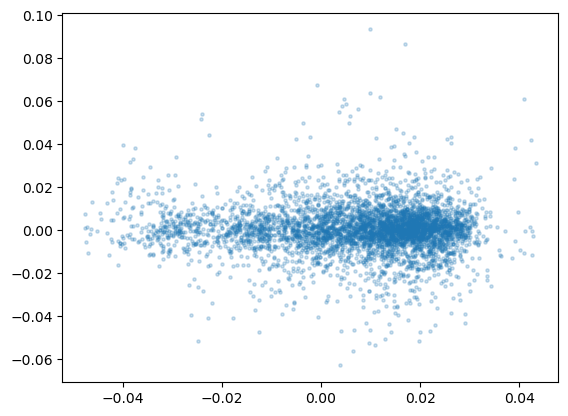

In [49]:
plt.plot(y_pred_cal, y_gt_cal, "o", ms=2.3, alpha=0.23)


Critical Scaling Factor: 0.014608207071886684
Prediction/Target STD Ratio: 146.02%


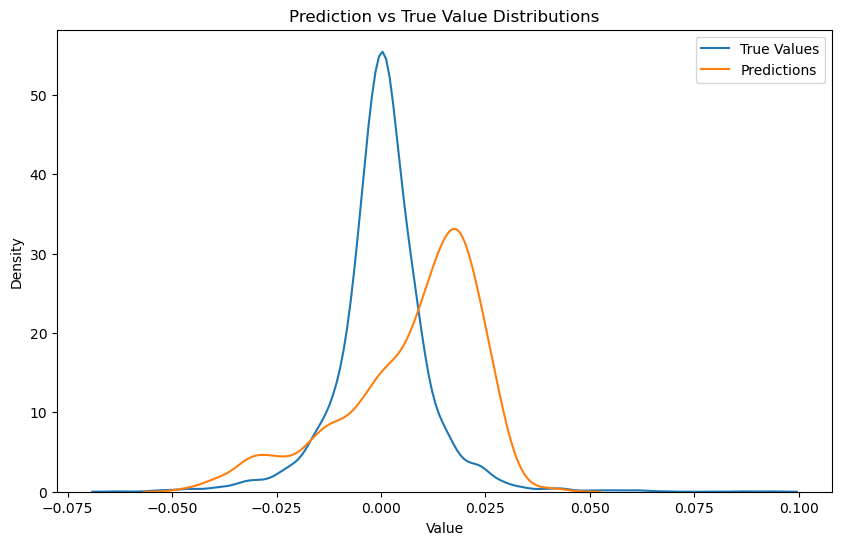

In [50]:
# Analyze scaling factors
scale_factor = target_scaler.scale_[0]
print(f"\nCritical Scaling Factor: {scale_factor}")



# Check prediction magnitudes
pred_scale_ratio = np.std(y_pred_cal) / np.std(y_gt_cal)
print(f"Prediction/Target STD Ratio: {pred_scale_ratio:.2%}")

# Plot density comparison
plt.figure(figsize=(10,6))
sns.kdeplot(y_gt_cal, label='True Values')
sns.kdeplot(y_pred_cal, label='Predictions')
plt.title("Prediction vs True Value Distributions")
plt.xlabel("Value")
plt.legend()
plt.show()

In [51]:
def compute_returns(
    df_trading: pd.DataFrame, cost: float = 0.001
):  # 0.1% transaction cost per unit change in position

    signal = df_trading["signal"]
    position_change = (
        signal.diff().abs().fillna(0)
    )  # First row has no previous position

    next_r = df_trading["log_ret"].shift(-1)

    # Strategy return net of transaction costs
    my_ret = next_r * signal - position_change * cost

    pr = np.nansum(my_ret[my_ret > 0]) / np.abs(np.nansum(my_ret[my_ret < 0]))
    sharpe = np.nanmean(my_ret.dropna()) / np.nanstd(my_ret.dropna(), ddof=1)

    return my_ret, pr, sharpe

In [52]:
len(y_pred_cal)
# val_split
offset = len( df_final.iloc[val_split:]) - len(y_pred_cal)

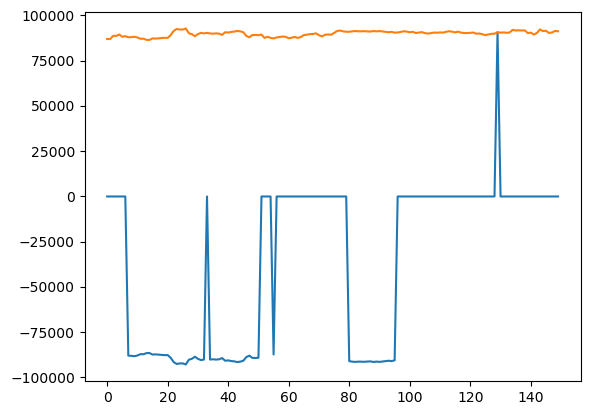

In [53]:
dftr = df_final.iloc[val_split + offset:].copy()

signal = np.zeros_like(y_pred_cal)
signal[y_pred_cal>uq] = 1
signal[y_pred_cal<lq] = -1


# signal = utils.generate_positions(signal, horizon=N//5)

signal = pd.DataFrame({"signal":signal})
dftr["signal"] = signal.values

# dftr["signal"] = dftr["signal"].rolling(N//5).mean().fillna(0)




position_change = (
        signal.diff().abs().fillna(0)
    )  # First row has no previous position


next_r = dftr["log_ret"].shift(-1)

cost = 0.00
my_ret = next_r.values * signal.values.flatten() - position_change.values.flatten() * cost


plt.plot(dftr["close"].values[100:250] *signal.values[100:250].flatten())
plt.plot(dftr["close"].values[100:250])



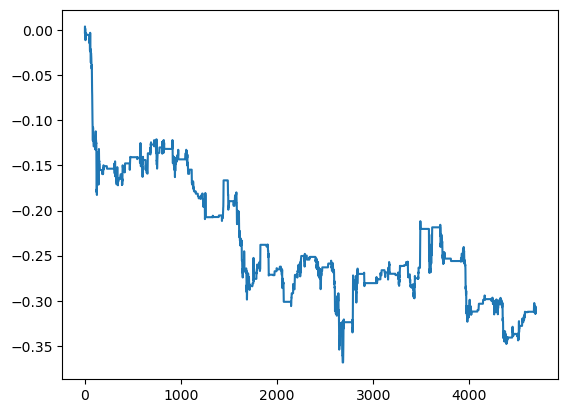

In [54]:
plt.plot(np.cumsum(my_ret))

In [55]:
dftr["log_ret"]

2024-11-08 12:00:00    0.001751
2024-11-08 13:00:00    0.002633
2024-11-08 14:00:00   -0.006790
2024-11-08 15:00:00    0.008881
2024-11-08 16:00:00   -0.006675
                         ...   
2025-05-22 20:00:00   -0.001006
2025-05-22 21:00:00   -0.002207
2025-05-22 22:00:00    0.001709
2025-05-22 23:00:00    0.006064
2025-05-23 00:00:00   -0.000740
Name: log_ret, Length: 4693, dtype: float64

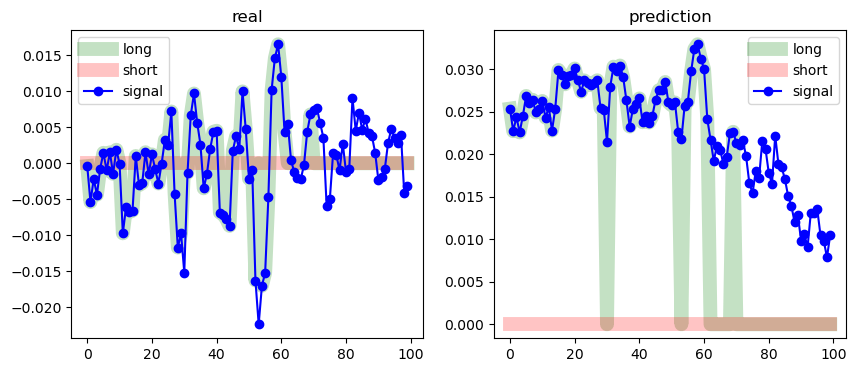

In [56]:

sep_signal_l = dftr["signal"].values.copy()
sep_signal_sh = dftr["signal"].values.copy()

sep_signal_l[sep_signal_l==-1] = 0
sep_signal_sh[sep_signal_sh==1] = 0
sep_signal_sh = np.abs(sep_signal_sh)


start = 2400
end = 2500


fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=False, sharex=True)

plot_holder = [
    [
        y_gt_cal[start:end] * sep_signal_l[start:end],
        y_gt_cal[start:end] * sep_signal_sh[start:end],
        y_gt_cal[start:end],

    ],

    [
        y_pred_cal[start:end] * sep_signal_l[start:end],
        y_pred_cal[start:end] * sep_signal_sh[start:end],
        y_pred_cal[start:end],
    ]
]

styles = ["g", "r", "bo-", ]

labels = ["long", "short", "signal"]
titles = ["real", "prediction"]

for i, plot in enumerate(plot_holder):
    for j, (overlay, style) in enumerate(zip(plot, styles)):

        if "b" in style:
            _x = np.arange(len(overlay))
            axs[i].plot(_x, overlay, style, label=f"{labels[j]}")
        else:
            _x = np.arange(len(overlay))
            axs[i].plot(_x[:], overlay[:], style, label=f"{labels[j]}", lw=10, alpha=0.23)
    axs[i].set_title(titles[i])
    axs[i].legend()
  

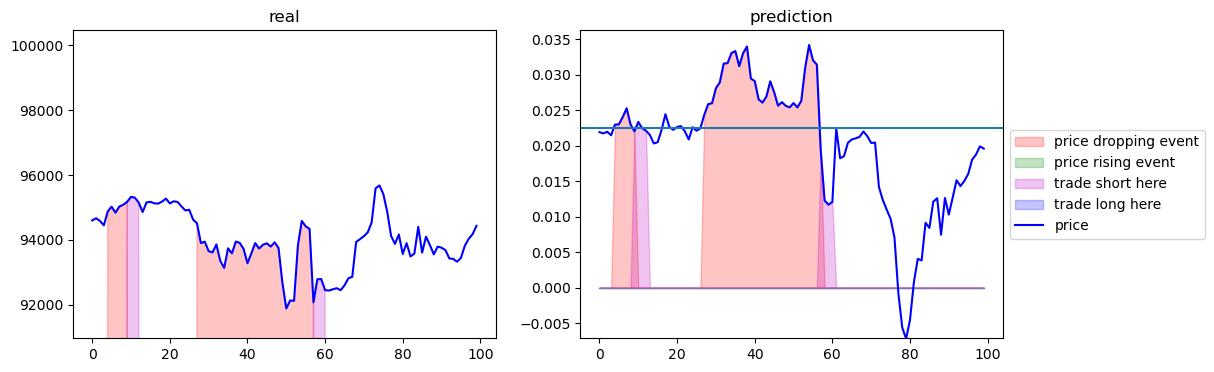

In [57]:

sep_signal_l = dftr["signal"].values.copy()
sep_signal_sh = dftr["signal"].values.copy()

sep_signal_l[sep_signal_l==-1] = 0
sep_signal_sh[sep_signal_sh==1] = 0
sep_signal_sh = np.abs(sep_signal_sh)

def filter_events(arr, min_event_size=10):
    arr = np.asarray(arr)
    result = np.zeros_like(arr)
    i = 0
    while i < len(arr):
        if arr[i] == 1:
            # Find the length of the run of 1s starting at i
            j = i
            while j < len(arr) and arr[j] == 1:
                j += 1
            run_length = j - i
            if run_length >= min_event_size:
                result[i:j] = 1
            i = j  # Skip past the run
        else:
            i += 1
    return result

def construct_hold_mask(events, n_hold=5):
    events = np.asarray(events)
    hold_mask = np.zeros_like(events)
    i = 0
    while i < len(events):
        if events[i] == 1:
            # Skip through the event
            while i < len(events) and events[i] == 1:
                i += 1
            # Now i is at the first 0 after the event
            # Apply hold for the next n_hold steps
            hold_end = min(i + n_hold, len(events))
            hold_mask[i-1:hold_end] = 1
            i = hold_end  # Skip hold period
        else:
            i += 1
    return hold_mask

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def max_rolling(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.max(rolling,axis=axis)

sep_signal_l = filter_events(sep_signal_l, min_event_size=4)
sep_signal_sh = filter_events(sep_signal_sh, min_event_size=4)


sep_signal_l = pd.DataFrame({"val": sep_signal_l}).rolling(N//2).max().fillna(0)
sep_signal_sh = pd.DataFrame({"val": sep_signal_sh}).rolling(N//2).max().fillna(0)

sep_signal_l = sep_signal_l.values.ravel()
sep_signal_sh = sep_signal_sh.values.ravel()



n_hold = 3
hold_long = construct_hold_mask(sep_signal_sh, n_hold=n_hold)
hold_short = construct_hold_mask(sep_signal_l, n_hold=n_hold)


start =1200
end = 1300


fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=False, sharex=True)

plot_holder = [
    [
        dftr["close"][start:end] * sep_signal_l[start:end],
        dftr["close"][start:end] * sep_signal_sh[start:end],
        dftr["close"][start:end] * hold_short[start:end],
        dftr["close"][start:end] * hold_long[start:end],
        dftr["close"][start:end],

    ],

    [
        y_pred_cal[start:end] * sep_signal_l[start:end],
        y_pred_cal[start:end] * sep_signal_sh[start:end],
        y_pred_cal[start:end] * hold_short[start:end],
        y_pred_cal[start:end] * hold_long[start:end],
        y_pred_cal[start:end],
    ]
]

styles = ["g", "r", "m", "m", "b-", ]

labels = ["price dropping event", "price rising event", "trade short here", "trade long here", "price"]
titles = ["real", "prediction"]
fill_cols = ["r", "g", "m", "b"]


for i, plot in enumerate(plot_holder):
    for j, (overlay, style) in enumerate(zip(plot, styles)):

        if "b" in style:
            _x = np.arange(len(overlay))
            axs[i].plot(_x, overlay, style, label=f"{labels[j]}")
            axs[i].set_ylim(overlay.min() - 0.01*overlay.min())
        else:
            _x = np.arange(len(overlay))
            axs[i].fill_between(_x[:], overlay[:], label=f"{labels[j]}", alpha=0.23, color=fill_cols[j])
    
    axs[i].set_title(titles[i])

    if i==len(titles)-1:
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].axhline(y=uq)
        axs[i].axhline(y=lq)
  

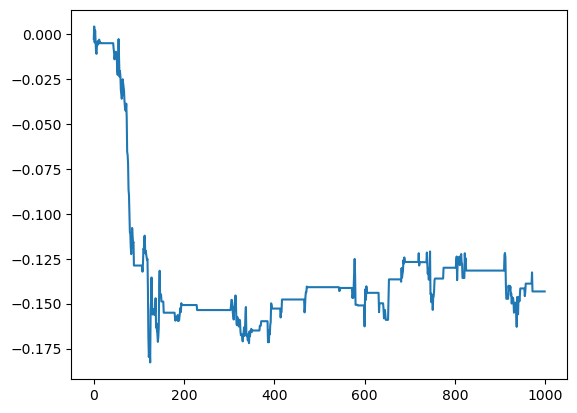

In [58]:
plt.plot(np.cumsum(my_ret)[:1000])

In [59]:
hold_long + -1*hold_short

array([0., 0., 0., ..., 0., 0., 1.])

without costs:
profit factor: 1.2419083201585346, sharpe: 0.018111868335504308, sharpe ann: 1.695358666729367
with costs:
profit factor: 0.9656799971504938, sharpe: -0.00311983649404754, sharpe ann: -0.2920318180865788


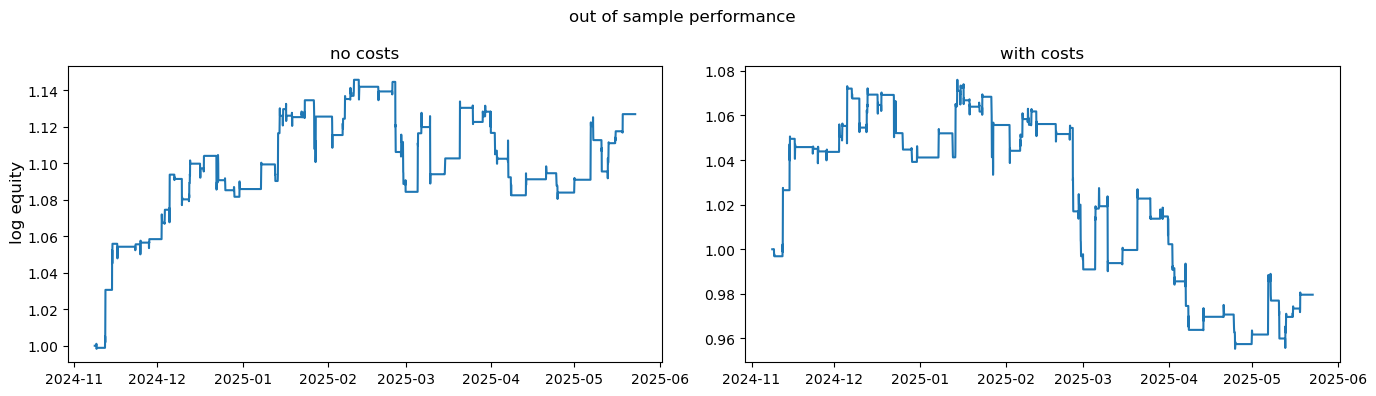

In [60]:
dftr_final = dftr.copy()
dftr_final["signal"] = -1* hold_long + 1*hold_short

my_ret, pr, sharpe = compute_returns(dftr_final, cost=0.00)

my_ret_fees, pr_fees, sharpe_fees = utils.compute_returns(dftr_final, cost=0.001)

fig, axs = plt.subplots(1,2, figsize=(14,4))

axs[0].plot(dftr_final["time"], np.exp(np.nancumsum(my_ret)))
axs[0].set_title("no costs")

axs[1].plot(dftr_final["time"], np.exp(np.nancumsum(my_ret_fees)))
axs[1].set_title("with costs")

fig.supylabel("log equity")
fig.suptitle("out of sample performance")
plt.tight_layout()

print("without costs:")
print(f"profit factor: {pr}, sharpe: {sharpe}, sharpe ann: { np.nanmean(my_ret) * 8760 / (np.nanstd(my_ret) * np.sqrt(8760)) }")
print("with costs:")
print(f"profit factor: {pr_fees}, sharpe: {sharpe_fees}, sharpe ann: { np.nanmean(my_ret_fees) * 8760 / (np.nanstd(my_ret_fees) * np.sqrt(8760)) }")

In [186]:
dftr_final["signal"].values

array([0., 0., 0., ..., 0., 0., 0.])

array([0.00015843])

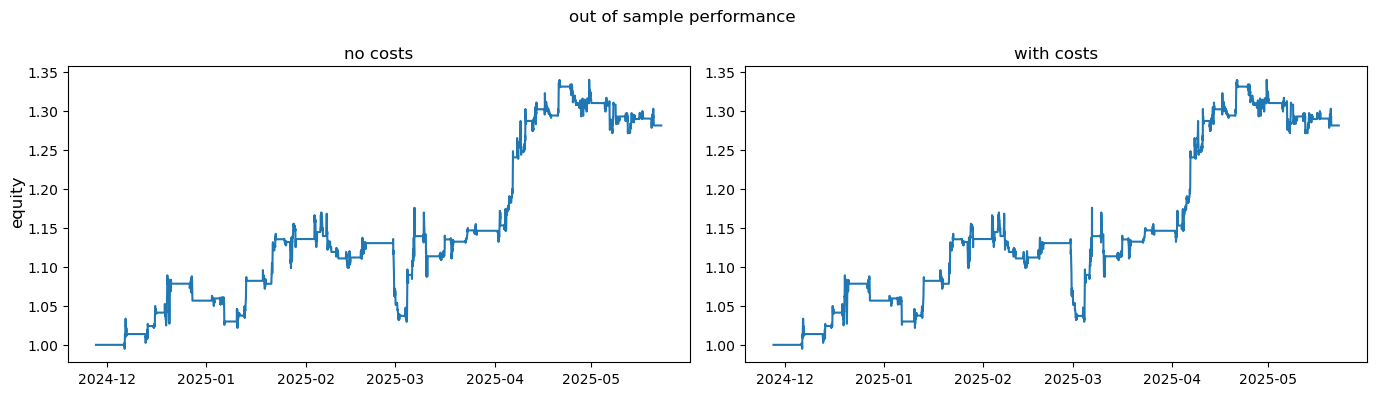

In [187]:
fig, axs = plt.subplots(1,2, figsize=(14,4))

axs[0].plot(dftr["time"], np.exp(np.nancumsum(my_ret)))
axs[0].set_title("no costs")

axs[1].plot(dftr["time"], np.exp(np.nancumsum(my_ret)))
axs[1].set_title("with costs")

fig.supylabel("equity")
fig.suptitle("out of sample performance")
plt.tight_layout()
target_scaler.mean_

In [563]:
np.array(all_preds[:1000])
all_targets[:10]

array([-0.22873111, -0.40103284,  0.20234856,  0.2828024 ,  0.2565044 ,
        0.4464353 ,  0.33832657,  0.14335072,  0.12347762,  0.15044196],
      dtype=float32)

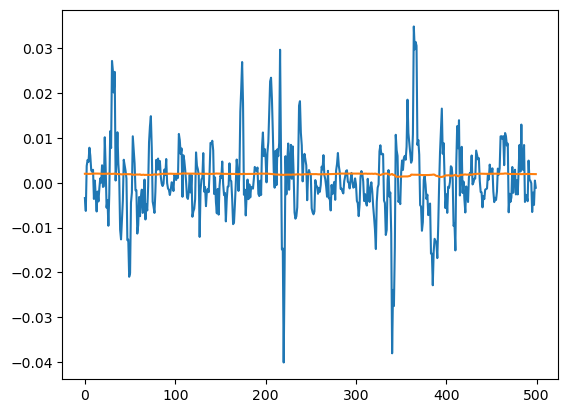

In [564]:

plt.plot(all_targets_sc[:500])
plt.plot(5*all_preds_sc[:500])

<Axes: ylabel='Count'>

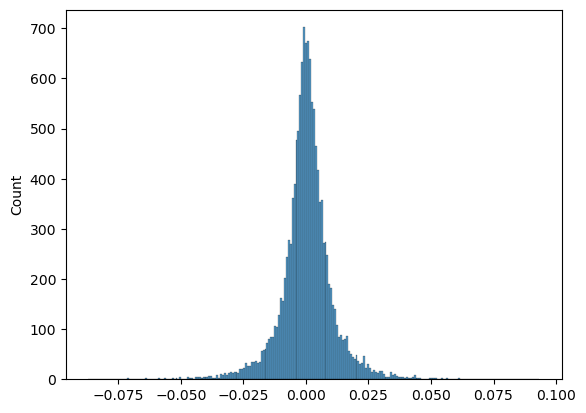

In [565]:
sns.histplot(all_targets_sc)

In [734]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"Training samples: {len(train_loader.dataset):,}")

Model parameters: 2,593
Training samples: 17,910


[Phase 1] Epoch 001: Train Loss: 0.6636 | Val Loss: 0.5265
[Phase 1] Epoch 002: Train Loss: 0.6622 | Val Loss: 0.5297
[Phase 1] Epoch 003: Train Loss: 0.6618 | Val Loss: 0.5260
[Phase 1] Epoch 004: Train Loss: 0.6617 | Val Loss: 0.5310
[Phase 1] Epoch 005: Train Loss: 0.6616 | Val Loss: 0.5283
[Phase 1] Epoch 006: Train Loss: 0.6608 | Val Loss: 0.5272
[Phase 1] Epoch 007: Train Loss: 0.6605 | Val Loss: 0.5273
[Phase 1] Epoch 008: Train Loss: 0.6601 | Val Loss: 0.5282
Early stopping base model!

Starting Phase 2: training output scaler...
[Phase 2] Epoch 001: Train Loss: 0.6695 | Val Loss: 0.5254
[Phase 2] Epoch 002: Train Loss: 0.6618 | Val Loss: 0.5268
[Phase 2] Epoch 003: Train Loss: 0.6615 | Val Loss: 0.5267
[Phase 2] Epoch 004: Train Loss: 0.6613 | Val Loss: 0.5285
[Phase 2] Epoch 005: Train Loss: 0.6614 | Val Loss: 0.5286
[Phase 2] Epoch 006: Train Loss: 0.6613 | Val Loss: 0.5275
Early stopping scaler!

Test Results:
MSE: 0.5892
RMSE: 0.7676
MAE: 0.5145


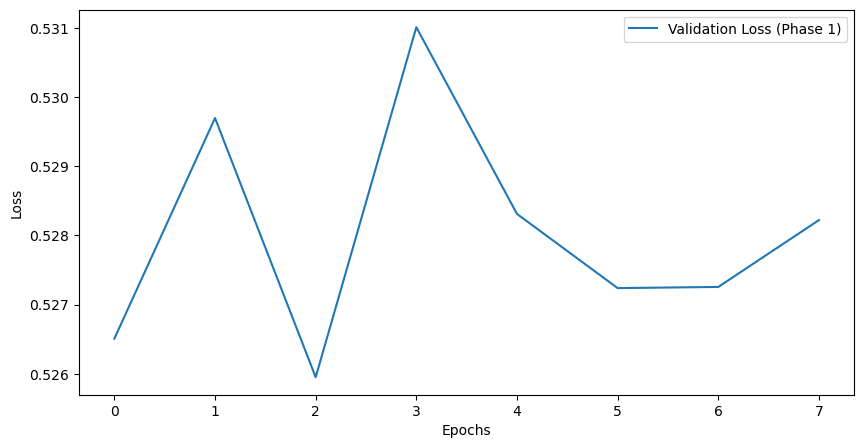

In [296]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ---------- 1. Output Scaler Modules ----------
class LinearOutputScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 1)

    def forward(self, x):
        return self.layer(x.unsqueeze(-1)).squeeze(-1)

class MLPOutputScaler(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x.unsqueeze(-1)).squeeze(-1)

# ---------- 2. Wrapper Model ----------
class ScaledModel(nn.Module):
    def __init__(self, base_model, scaler=None):
        super().__init__()
        self.base_model = base_model
        self.scaler = scaler if scaler else nn.Identity()

    def forward(self, x):
        out = self.base_model(x)
        return self.scaler(out)

# ---------- 3. Setup ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Base model
b_model = LSTMReg(
    input_dim=X_train.shape[-1],
    hidden_dim=32,
    num_layers=1,
    dropout=0.0
).to(device)

# Phase 1: no scaler yet
model = ScaledModel(b_model).to(device)
criterion = MomentMatchingLoss(0.05)
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-4,
    max_lr=1e-3,
    step_size_up=500,
    cycle_momentum=False
)

# ---------- 4. Phase 1: Train base model ----------
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
early_stop = False

for epoch in range(25):
    if early_stop:
        print("Early stopping base model!")
        break

    model.train()
    epoch_train_loss = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())

    model.eval()
    epoch_val_loss = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss = criterion(val_outputs.squeeze(), y_val_batch)
            epoch_val_loss.append(val_loss.item())

    train_loss = np.mean(epoch_train_loss)
    val_loss = np.mean(epoch_val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_base_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            early_stop = True

    scheduler.step()

    print(f'[Phase 1] Epoch {epoch+1:03}: '
          f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

# ---------- 5. Phase 2: Train output scaler ----------
print("\nStarting Phase 2: training output scaler...")

# Load best base model and freeze it

model.load_state_dict(torch.load('best_base_model.pth'))
for p in b_model.parameters():
    p.requires_grad = False

# Choose scaler
scaler = LinearOutputScaler().to(device)
# scaler = MLPOutputScaler().to(device)

# Wrap base model + scaler
model = ScaledModel(b_model, scaler=scaler).to(device)

# New optimizer for scaler only
optimizer = torch.optim.Adam(model.scaler.parameters(), lr=1e-3)

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(25):
    if early_stop:
        print("Early stopping scaler!")
        break

    model.train()
    epoch_train_loss = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())

    model.eval()
    epoch_val_loss = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss = criterion(val_outputs.squeeze(), y_val_batch)
            epoch_val_loss.append(val_loss.item())

    train_loss = np.mean(epoch_train_loss)
    val_loss = np.mean(epoch_val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_full_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            early_stop = True

    print(f'[Phase 2] Epoch {epoch+1:03}: '
          f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

# ---------- 6. Evaluate on test set ----------
model.load_state_dict(torch.load('best_full_model.pth'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        preds = model(X_test_batch).cpu().numpy().flatten()
        all_preds.extend(preds)
        all_targets.extend(y_test_batch.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Inverse scaling (if needed)
all_preds_sc = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()
all_targets_sc = target_scaler.inverse_transform(all_targets.reshape(-1, 1)).flatten()

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)

print(f'\nTest Results:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

# ---------- 7. Plot ----------
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss (Phase 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
